In [ ]:
# GPU
!pip install torch==1.8.1 torchaudio==0.8.1 fastcore==1.3.20 fastaudio
!pip install pycaret-nightly

!pip install pytorch-lightning
!pip install omegaconf
!pip install noisereduce

Start of kernel restart

In [1]:
import os
import numpy as np

import pandas as pd
import soundfile as sf

import librosa
from tqdm import tqdm

import pandas as pd
from fastaudio.all import *
# from fastai_xla_extensions.all import *

import torch
import torchaudio
import fastcore
import fastai
import fastaudio
import torchaudio
torchaudio.set_audio_backend("sox_io")
from fastai.vision.all import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.express as px

from sklearn.preprocessing import LabelEncoder

PATH_DATASET = "../input/la-spoof/LA"
PATH_CM = os.path.join(PATH_DATASET, "ASVspoof2019_LA_cm_protocols")
PATH_CM_TRAIN = os.path.join(PATH_CM, "ASVspoof2019.LA.cm.train.trn.txt")
PATH_CM_DEV = os.path.join(PATH_CM, "ASVspoof2019.LA.cm.dev.trl.txt")
PATH_AUDIO_DIR = os.path.join(PATH_DATASET, "dev_train", "flac")

PATH_ASV = os.path.join(PATH_DATASET, "ASVspoof2019_LA_asv_protocols")
PATH_ASV_TRAIN = [os.path.join(PATH_ASV, "ASVspoof2019.LA.asv.dev.female.trl.txt"), os.path.join(PATH_ASV, "ASVspoof2019.LA.asv.dev.gi.trl.txt")]
PATH_ASV_TRAIN.append(os.path.join(PATH_ASV, "ASVspoof2019.LA.asv.dev.male.trl.txt"))

df_train = pd.read_csv(PATH_CM_TRAIN, sep=" ", header=None)
df_train.columns = ["Speaker_ID", "Audio_File_Name", "-", "System_ID", "Key"]
df_train.drop(['-', 'System_ID'], axis = 1, inplace = True)

print("before", len(df_train))
li = []

for i in PATH_ASV_TRAIN:
    d = pd.read_csv(i, sep=" ", header=None)
    d.columns = ["Speaker_ID", "Audio_File_Name", "System_ID", "Key"]
    d.drop(['System_ID'], axis = 1, inplace = True)
    d["Key"] = d["Key"].apply(lambda x: x if x == "spoof" else "bonafide")
    li.append(d)

li.append(df_train)

df_train = pd.concat(li, axis=0, ignore_index=True)

print("after", len(df_train))
df_train.drop_duplicates(subset='Audio_File_Name', keep="first", inplace = True)
print("after remove duplicate", len(df_train))

# Take small dataset for quick experiments
def sample_equal(df, sample_size):
    frames = []
    classes = df["Key"].unique()

    for i in classes:
        print(len(df[df["Key"] == i]))
        g = df[df["Key"] == i].sample(sample_size)
        frames.append(g)

    equally_sampled = pd.concat(frames)
    return equally_sampled

df_test = sample_equal(df_train, 1000)
df_train = sample_equal(df_train, 5000)
df_train.sample(frac=1.0)
df_test.sample(frac=1.0)

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '
/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


before 25380
after 84476
after remove duplicate 50224
5128
45096
5128
45096


,Speaker_ID,Audio_File_Name,Key
20598,LA_0071,LA_D_5512289,bonafide
1597,LA_0078,LA_D_8316995,bonafide
74791,LA_0088,LA_T_2179529,spoof
20827,LA_0070,LA_D_7534463,bonafide
80320,LA_0097,LA_T_2074796,spoof
...,...,...,...
61466,LA_0097,LA_T_4124430,bonafide
14486,LA_0069,LA_D_9956149,spoof
59867,LA_0084,LA_T_9881753,bonafide
1302,LA_0078,LA_D_1323454,bonafide


In [2]:
df_train.head()

,Speaker_ID,Audio_File_Name,Key
1344,LA_0078,LA_D_6716159,bonafide
59232,LA_0080,LA_T_1625761,bonafide
20703,LA_0076,LA_D_1158837,bonafide
59273,LA_0080,LA_T_4140258,bonafide
20843,LA_0070,LA_D_6700006,bonafide


In [3]:
le = LabelEncoder()
le = le.fit(df_train["Key"])
df_train["Key"] = le.transform(df_train["Key"])
df_test["Key"] = le.transform(df_test["Key"])

df_train.head()

,Speaker_ID,Audio_File_Name,Key
1344,LA_0078,LA_D_6716159,0
59232,LA_0080,LA_T_1625761,0
20703,LA_0076,LA_D_1158837,0
59273,LA_0080,LA_T_4140258,0
20843,LA_0070,LA_D_6700006,0


In [4]:
df_test.head()

,Speaker_ID,Audio_File_Name,Key
59615,LA_0083,LA_T_1504888,0
1563,LA_0078,LA_D_6548870,0
59601,LA_0082,LA_T_9634249,0
947,LA_0078,LA_D_6610055,0
904,LA_0077,LA_D_7546022,0


In [5]:
le.transform(["spoof", "bonafide"])

array([1, 0])

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1344 to 25864
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Speaker_ID       10000 non-null  object
 1   Audio_File_Name  10000 non-null  object
 2   Key              10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


# Baseline

In [7]:
from collections import Counter

Counter(df_train["Key"])

Counter({0: 5000, 1: 5000})

In [8]:
from sklearn.metrics import accuracy_score

pred_baseline = [1] *len(df_test)
accuracy_score(df_test["Key"], pred_baseline)

0.5

# Create Spectrogram

In [9]:
# aud2mfcc = AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256,'n_mels':128})
aud2spec = AudioToSpec.from_cfg(AudioConfig.BasicMelSpectrogram(n_fft=512))

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


# Making Pipeline

In [10]:
# item_tfms = [RemoveSilence(),ResizeSignal(1000), aud2mfcc, Delta()]
item_tfms = [RemoveSilence(), ResizeSignal(2000), MaskFreq(num_masks = 2), MaskTime(num_masks = 2), aud2spec]

aud_digit = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader('Audio_File_Name', pref=PATH_AUDIO_DIR+"/", suff='.flac'),
                 get_y = ColReader('Key'),
                 splitter = RandomSplitter(),
                 item_tfms = item_tfms)

In [11]:
# batch size 128
dls = aud_digit.dataloaders(df_train, bs=256)
dls.c

/opt/conda/lib/python3.7/site-packages/fastaudio/augment/spectrogram.py:21: UserWarning: You are trying to apply a MaskFreq to an AudioTensor torch.Size([1, 32000])
  f"You are trying to apply a {type(self).__name__} to an AudioTensor {audio.shape}"
/opt/conda/lib/python3.7/site-packages/fastaudio/augment/spectrogram.py:21: UserWarning: You are trying to apply a MaskTime to an AudioTensor torch.Size([1, 32000])
  f"You are trying to apply a {type(self).__name__} to an AudioTensor {audio.shape}"


2

In [12]:
x,y = dls.one_batch()
print(x.shape)
print(y.shape)

torch.Size([256, 1, 128, 126])
torch.Size([256])


/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


<Figure size 432x288 with 0 Axes>

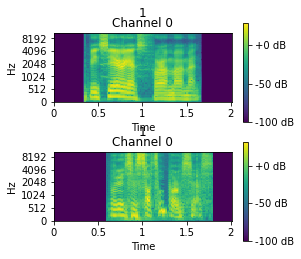

In [13]:
plt.figure()
dls.show_batch()

# Train

In [14]:
def alter_learner(learn, n_channels=1):
    "Adjust a `Learner`'s model to accept `1` channel"
    layer = learn.model[0][0]
    layer.in_channels=n_channels
    layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
    learn.model[0][0] = layer

def audio_learner(dls, arch, loss_func, metrics):
    "Prepares a `Learner` for audio processing"
    learn = Learner(dls, arch, loss_func, metrics=metrics,
                      cbs = [EarlyStoppingCallback(monitor='accuracy', patience=5),
                         ActivationStats(with_hist=True)]).to_fp16()
    n_c = dls.one_batch()[0].shape[1]
    print(n_c)
    if n_c == 1:
        alter_learner(learn)
    return learn

In [15]:
#PyTorch
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs = torch.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        targets = targets.to(torch.float32)

        intersection = (inputs * targets).sum()                        
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy_with_logits(inputs, targets)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE

In [16]:
import torch.nn as nn

learn = audio_learner(dls,
                      xresnet18(n_out = 2),
                      # DiceBCELoss(),
                      LabelSmoothingCrossEntropy(),
                      # BCEWithLogitsLossFlat(),
                      accuracy)

1


In [17]:
sr = learn.lr_find(stop_div = False)
sr

/opt/conda/lib/python3.7/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


KeyboardInterrupt: 

In [19]:
learn = learn.to_non_native_fp32()

learn.fit(3, lr = 0.017)

epoch,train_loss,valid_loss,accuracy,time
0,0.462953,0.854255,0.576500,26:44
1,0.371676,0.626525,0.737500,25:59
2,0.322868,0.499201,0.798000,26:36


In [20]:
learn.fit(1, lr = 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.264911,0.283126,0.960000,25:32
1,0.259117,0.422305,0.847000,25:48


# Inference

In [21]:
preds = learn.get_preds(dl=dls.test_dl(df_test), act=sigmoid)
preds

(tensor([[0.8439, 0.0493],
         [0.8696, 0.0276],
         [0.7092, 0.0851],
         ...,
         [0.2980, 0.5278],
         [0.2718, 0.3885],
         [0.2826, 0.5894]]),
 None)

In [22]:
preds = torch.argmax(preds[0], dim = 1)

In [23]:
Counter(preds.tolist())

Counter({0: 1303, 1: 697})

In [24]:
accuracy_score(df_test["Key"], preds)

0.8475